Settings

In [1]:
# display information about available GPU devices
!nvidia-smi

Tue Apr 15 21:40:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   78C    P0             37W /   40W |    1159MiB /   4096MiB |     57%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Import libraries

In [2]:
# Visualization purpose
%pip install tensorboardX
%pip install tensorboard
%pip install tensorboard-plugin-customizable-plots

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Chia dataset thành train/val/test.
%pip install split-folders

# Tối ưu hóa tham số mô hình.
%pip install optuna

# Lấy thông tin GPU từ NVIDIA.
%pip install --upgrade nvidia-ml-py3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import tensorflow as tf
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

C:\Users\MSII\AppData\Local\Temp\ipykernel_12204\152443845.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Data Preprcessing

In [5]:
data_dir = 'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\dataset\\'
experiment_name = "Transfer Learning"

In [6]:
# Quét tất cả các tệp xem có phải ảnh đuôi .PNG, ... không và nếu không phải thì xóa
count=0
image_extensions = [".png", ".jpg"]
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

E:\HOC_TAP\Nam_3\HOC_KY_2\Do_an_chuyen_nganh_1\source_code_hoc_may\source_code\dataset\cardboard\cardboard_2088.jpg is not an image
E:\HOC_TAP\Nam_3\HOC_KY_2\Do_an_chuyen_nganh_1\source_code_hoc_may\source_code\dataset\cardboard\cardboard_2088.jpg is a None, not accepted by TensorFlow
E:\HOC_TAP\Nam_3\HOC_KY_2\Do_an_chuyen_nganh_1\source_code_hoc_may\source_code\dataset\cardboard\cardboard_313.jpg is not an image
E:\HOC_TAP\Nam_3\HOC_KY_2\Do_an_chuyen_nganh_1\source_code_hoc_may\source_code\dataset\cardboard\cardboard_313.jpg is a None, not accepted by TensorFlow
E:\HOC_TAP\Nam_3\HOC_KY_2\Do_an_chuyen_nganh_1\source_code_hoc_may\source_code\dataset\paper\paper_1433.jpg is not an image
E:\HOC_TAP\Nam_3\HOC_KY_2\Do_an_chuyen_nganh_1\source_code_hoc_may\source_code\dataset\paper\paper_1433.jpg is a None, not accepted by TensorFlow
E:\HOC_TAP\Nam_3\HOC_KY_2\Do_an_chuyen_nganh_1\source_code_hoc_may\source_code\dataset\paper\paper_1678.jpg is a webp, not accepted by TensorFlow
E:\HOC_TAP\Nam

In [7]:
os.mkdir('E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\data') # Tạo thư mục mới tên data

In [8]:
os.chdir('E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\data') # Thay đổi thư mục hiện tại sang thư mục data

In [9]:
os.getcwd()

'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\data'

In [10]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [11]:
os.chdir('E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\') # Thay đổi thư mục hiện tại

In [12]:
os.getcwd()

'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code'

In [13]:
SEED = 42

In [14]:
splitfolders.ratio("E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 19750 files [00:31, 631.77 files/s]


In [15]:
data_dir

'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\dataset\\'

In [16]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

In [17]:
train_path = 'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\data\\train'
val_path = 'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\data\\val'
test_path = 'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\data\\test'

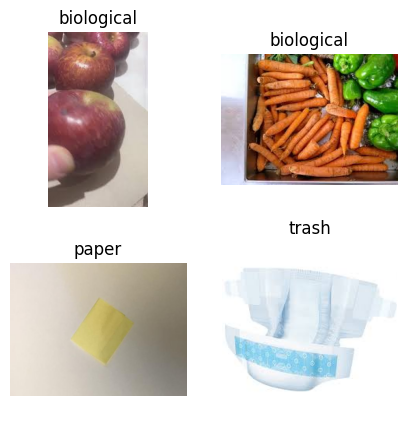

In [18]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) # hiển thị 4 hình ảnh
axes = axes.ravel()

for i in np.arange(0, 4):

    category = random.choice(os.listdir(train_path)) # chọn lớp ngẫu nhiên
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) # lựa chọn ngẫu nhiên một hình ảnh từ lớp

    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category)
    axes[i].axis('off')

In [19]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))
print(f"\nTotal number of train images: {total}")

Battery: 755
Biological: 797
Cardboard: 1458
Clothes: 4261
Glass: 2448
Metal: 816
Paper: 1339
Plastic: 1584
Shoes: 1581
Trash: 757

Total number of train images: 15796


In [20]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [21]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[755, 797, 1458, 4261, 2448, 816, 1339, 1584, 1581, 757]

C:\Users\MSII\AppData\Local\Temp\ipykernel_12204\2445126286.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


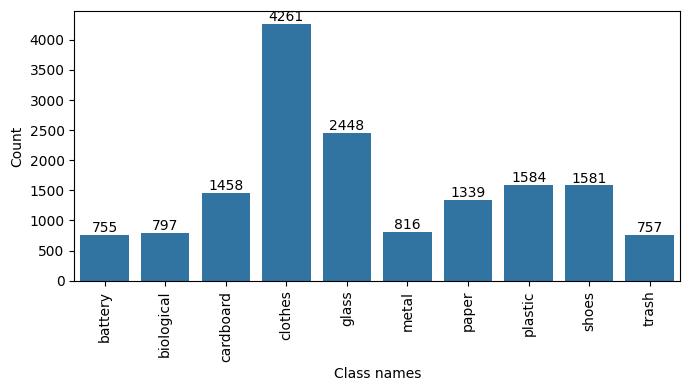

In [22]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

In [23]:
# Xóa các thư mục ảnh sao cho chỉ còn lại tối đa là 1000 ảnh
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category))
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1

    print(f'Deleted {delete} in {category}')

Deleted 0 in battery
Deleted 0 in biological
Deleted 458 in cardboard
Deleted 3261 in clothes
Deleted 1448 in glass
Deleted 0 in metal
Deleted 339 in paper
Deleted 584 in plastic
Deleted 581 in shoes
Deleted 0 in trash


In [24]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[755, 797, 1000, 1000, 1000, 816, 1000, 1000, 1000, 757]

C:\Users\MSII\AppData\Local\Temp\ipykernel_12204\1340998040.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


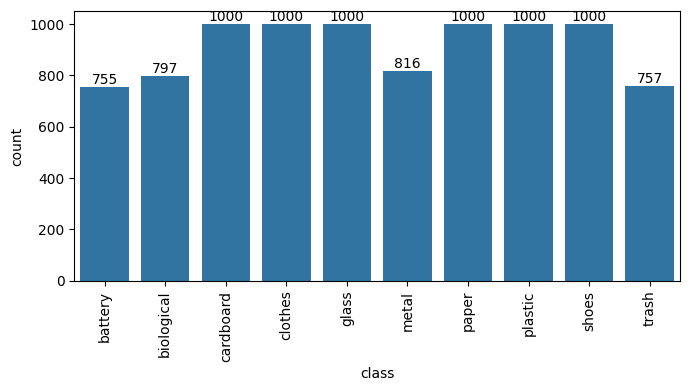

In [25]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

In [26]:
data_path = 'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\data'

In [27]:
# Tính chiều dài và chiểu cao trung bình của tất cả ảnh
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 414.3286
Mean Height: 406.1838


In [28]:
IMG_SIZE = (400, 400)
BATCH_SIZE = 32
writer = SummaryWriter()

In [29]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9125 files belonging to 10 classes.


In [30]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 1983 files belonging to 10 classes.


In [31]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 1971 files belonging to 10 classes.


In [32]:
# tạo các thư mục để lưu trữ log trong quá trình huấn luyện và kiểm tra mô hình
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)

Building the model

In [33]:
# tải mô hình
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [34]:
base_model.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 400, 400,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 200, 200,  │        648 │ rescaling[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 200, 200,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 200, 200,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 200, 200,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 200, 200,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 200, 200,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 200, 200,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 200, 200,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 200, 200,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 200, 200,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 200, 200,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 200, 200,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 100, 100,  │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 100, 100,  │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 100, 100,  │          0 │ block2a_expand_b

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [35]:
# đóng băng tất cả các lớp trong base_model để không được cập nhật trong quá trình huấn luyện.
base_model.trainable = False

In [36]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2),
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

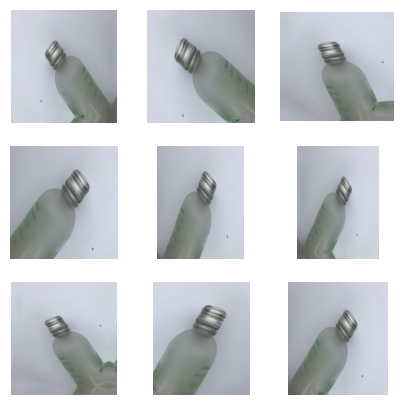

In [37]:
for image, _ in train_data.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [38]:
name="EfficientNetV2S"

EfficientNetV2S_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

In [39]:
EfficientNetV2S_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

In [40]:
EfficientNetV2S_model.summary()

Model: "EfficientNetV2S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, None, None,     │    20,331,360 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,496,618 (78.19 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [41]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)

    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)

    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):

    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [42]:
EfficientNetV2S_callback = create_callback(name)
EPOCH=15

In [43]:
import time
start_time = time.time()

# Train model
with tf.device('/GPU:0'):
  EfficientNetV2S_history = EfficientNetV2S_model.fit(train_data,
                                                    epochs=EPOCH,
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data,
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2S_callback)

Epoch 1/15


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7724 - loss: 0.7613

286/286 ━━━━━━━━━━━━━━━━━━━━ 1810s 6s/step - accuracy: 0.7727 - loss: 0.7603 - val_accuracy: 0.9330 - val_loss: 0.2227 - learning_rate: 0.0010
Epoch 2/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9129 - loss: 0.2788

286/286 ━━━━━━━━━━━━━━━━━━━━ 2020s 7s/step - accuracy: 0.9129 - loss: 0.2788 - val_accuracy: 0.9366 - val_loss: 0.2014 - learning_rate: 0.0010
Epoch 3/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9178 - loss: 0.2524

286/286 ━━━━━━━━━━━━━━━━━━━━ 1733s 6s/step - accuracy: 0.9179 - loss: 0.2523 - val_accuracy: 0.9411 - val_loss: 0.1783 - learning_rate: 0.0010
Epoch 4/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 1782s 6s/step - accuracy: 0.9309 - loss: 0.2152 - val_accuracy: 0.9386 - val_loss: 0.1854 - learning_rate: 0.0010
Epoch 5/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9330 - loss: 0.1958

286/286 ━━━━━━━━━━━━━━━━━━━━ 1745s 6s/step - accuracy: 0.9330 - loss: 0.1958 - val_accuracy: 0.9457 - val_loss: 0.1715 - learning_rate: 0.0010
Epoch 6/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 1715s 6s/step - accuracy: 0.9442 - loss: 0.1853 - val_accuracy: 0.9457 - val_loss: 0.1667 - learning_rate: 0.0010
Epoch 7/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 1706s 6s/step - accuracy: 0.9443 - loss: 0.1689 - val_accuracy: 0.9442 - val_loss: 0.1751 - learning_rate: 0.0010
Epoch 8/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9441 - loss: 0.1567
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


286/286 ━━━━━━━━━━━━━━━━━━━━ 1705s 6s/step - accuracy: 0.9441 - loss: 0.1567 - val_accuracy: 0.9482 - val_loss: 0.1779 - learning_rate: 0.0010
Epoch 9/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 1708s 6s/step - accuracy: 0.9523 - loss: 0.1377 - val_accuracy: 0.9467 - val_loss: 0.1647 - learning_rate: 2.0000e-04
Epoch 10/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 1712s 6s/step - accuracy: 0.9578 - loss: 0.1245 - val_accuracy: 0.9477 - val_loss: 0.1697 - learning_rate: 2.0000e-04
Epoch 11/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 1704s 6s/step - accuracy: 0.9629 - loss: 0.1186 - val_accuracy: 0.9482 - val_loss: 0.1638 - learning_rate: 2.0000e-04
Epoch 12/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9620 - loss: 0.1127

286/286 ━━━━━━━━━━━━━━━━━━━━ 1733s 6s/step - accuracy: 0.9620 - loss: 0.1127 - val_accuracy: 0.9493 - val_loss: 0.1627 - learning_rate: 2.0000e-04
Epoch 13/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9617 - loss: 0.1194

286/286 ━━━━━━━━━━━━━━━━━━━━ 1690s 6s/step - accuracy: 0.9617 - loss: 0.1194 - val_accuracy: 0.9503 - val_loss: 0.1607 - learning_rate: 2.0000e-04
Epoch 14/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 1689s 6s/step - accuracy: 0.9624 - loss: 0.1125 - val_accuracy: 0.9488 - val_loss: 0.1613 - learning_rate: 2.0000e-04
Epoch 15/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9655 - loss: 0.1038
Epoch 15: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
286/286 ━━━━━━━━━━━━━━━━━━━━ 1722s 6s/step - accuracy: 0.9655 - loss: 0.1038 - val_accuracy: 0.9467 - val_loss: 0.1608 - learning_rate: 2.0000e-04


In [44]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\logs", 'zip', "E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\logs")

'E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\logs.zip'

In [45]:
end_time = time.time()
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))
EfficientNetV2S_model.save("E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\garbage-classification.keras")

Total training time: 26173.43 seconds


In [46]:
writer.close()
train_writer.close()
test_writer.close()

In [47]:
EfficientNetV2S_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [48]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

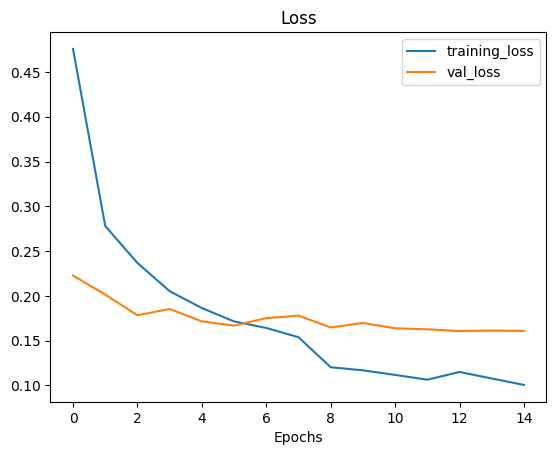

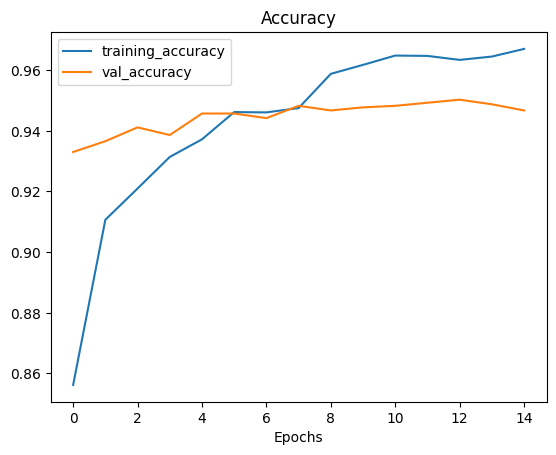

In [49]:
plot_loss_curves(EfficientNetV2S_history)

Model Evaluation

In [50]:
from tensorflow.keras.models import load_model

model = load_model(r"E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\garbage-classification.keras")
test_loss, test_accuracy = model.evaluate(test_data)
# test_loss, test_accuracy = EfficientNetV2S_model.evaluate(test_data, verbose=0)

e:\HOC_TAP\Phan_mem_code\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


62/62 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.9639 - loss: 0.1395


In [51]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.14242
Test Accuracy: 95.97%


In [52]:
pred_probs = EfficientNetV2S_model.predict(test_data, verbose=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 288s 5s/step


In [53]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

In [55]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.99      0.94      0.96        95
  biological       0.99      0.96      0.97       101
   cardboard       0.94      0.96      0.95       183
     clothes       1.00      0.99      1.00       534
       glass       0.97      0.94      0.96       307
       metal       0.85      0.98      0.91       102
       paper       0.93      0.92      0.93       168
     plastic       0.92      0.91      0.92       198
       shoes       0.98      0.99      0.99       199
       trash       0.90      0.92      0.91        96

    accuracy                           0.96      1983
   macro avg       0.95      0.95      0.95      1983
weighted avg       0.96      0.96      0.96      1983



In [56]:
import itertools

In [57]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

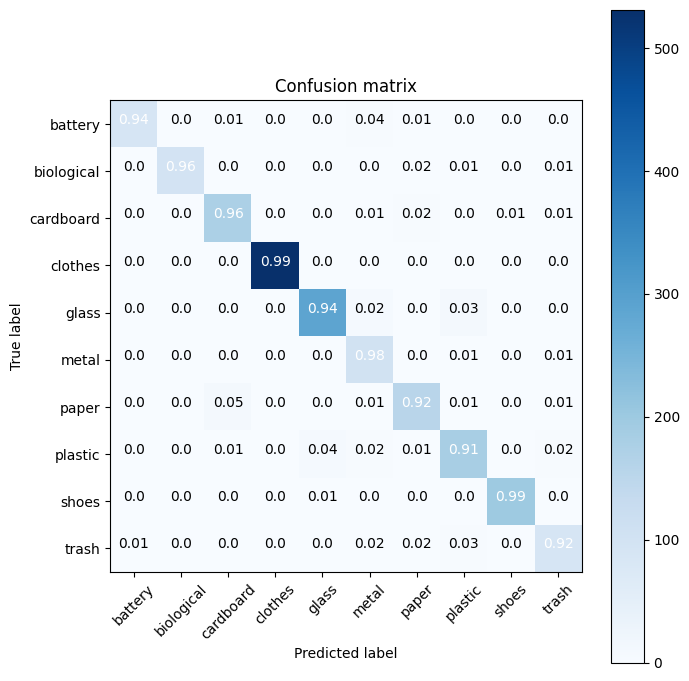

In [58]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

In [59]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename

        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
        pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class:
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False)

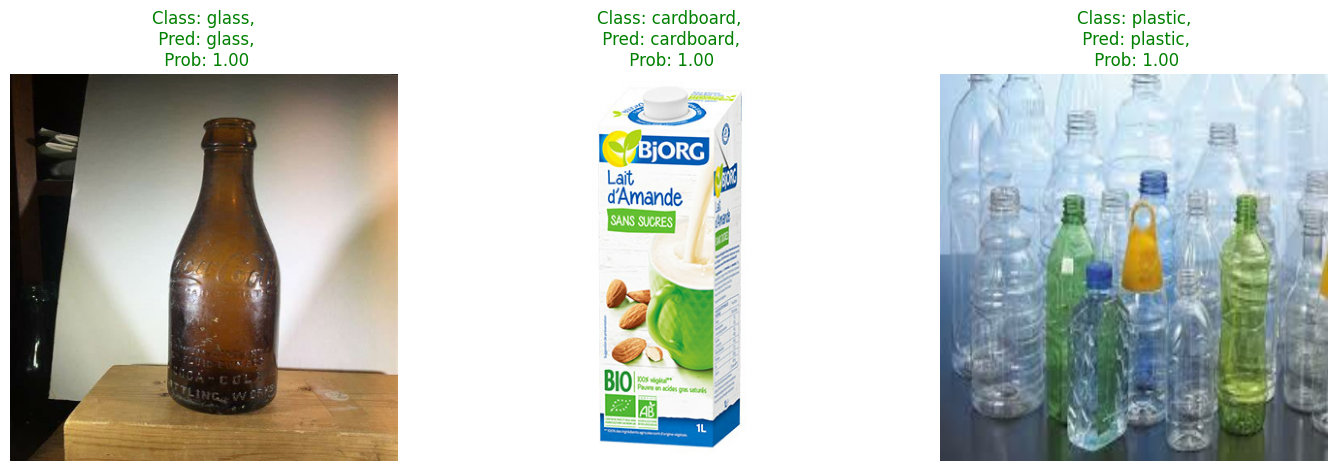

In [62]:
pred_random_images(EfficientNetV2S_model, test_path, class_names)

In [61]:
import pickle
pickle.dump(EfficientNetV2S_model,open("garbage-classification.h5","wb"))

In [11]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np



model = load_model(r"E:\\HOC_TAP\\Nam_3\\HOC_KY_2\\Do_an_chuyen_nganh_1\\source_code_hoc_may\\source_code\\garbage-classification.keras")


image_path = r'E:\HOC_TAP\Nam_3\HOC_KY_2\Do_an_chuyen_nganh_1\source_code_hoc_may\source_code\data\test\biological\biological_87.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(400, 400))

x = tf.keras.utils.img_to_array(image)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [12]:
x.shape
pred = model.predict(x)  # Predict the class probabilities
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[3.0867544e-05, 9.4813430e-01, 1.6999606e-04, 1.4455694e-02,
        8.8023773e-04, 1.8582596e-02, 5.0595880e-04, 4.7842432e-03,
        4.7032703e-03, 7.7528208e-03]], dtype=float32)

In [13]:
class_names = ['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']
result_index = np.argmax(pred)
print ('Model Prediction: ', class_names[result_index])

Model Prediction:  biological
